## I. Import + Load Data

In [1]:
# ------- IMPORTS
# -- model(s)
from cobras_ts.querier.labelquerier import LabelQuerier
from XQuerier import XQuerier
from xcobras_kmeans import XCOBRAS_kmeans
from model_explainer import XCobrasExplainer
import shap

# -- metrics
from sklearn.metrics import adjusted_rand_score

# -- plot(s)
from utils.plots import plot_2D, plot_boundary
import matplotlib.pyplot as plt

# -- dataset(s) 
from sklearn import datasets
from scipy.io import arff
import pandas as pd
import numpy as np

# -- others
import warnings
warnings.filterwarnings("ignore")


# ------- CREATE TOY DATASET
n_samples = 500
X_blob0, y_blob0 = datasets.make_blobs(n_samples=n_samples, centers=3, n_features=2, random_state=0)
X_blob1, y_blob1 = datasets.make_blobs(n_samples=n_samples, centers=3, n_features=2, random_state=1)
X_moons1, y_moons1 = datasets.make_moons(n_samples=n_samples, noise=0.1, random_state=1)
# on verra comment les print

# ------- READ REAL DATASET
PATH = "../../../datasets/deric benchmark/"
ARTIFICIAL = PATH+"artificial/"
REALWORLD = PATH+"real-world/"

datasets_path = [
    ARTIFICIAL+"target",
    REALWORLD+"wine",
    REALWORLD+"iris"
]

data = {}
for dataset_path in datasets_path:
    temp_data = arff.loadarff(open(dataset_path+".arff", 'r'))
    dataset_name = dataset_path.split("/")[-1]
    data[dataset_name] = pd.DataFrame(temp_data[0])
    data[dataset_name]["class"] = data[dataset_name]["class"].str.decode('utf-8') 

In [2]:
X = data["iris"].drop(["class"], axis=1)
y = data["iris"]["class"]

feature_names = X.columns

budget = 10

In [3]:
xai_querier = XQuerier(
    y.values,
    strat="commun_fraction",
    top_n = 3,
    threshold = 0.5
)
xcobras_kmeans = XCOBRAS_kmeans(budget, verbose=False)
print("Fitting...")
xcobras_kmeans.fit(X.values, feature_names=feature_names, y=xai_querier)
# xcobras_kmeans.fit(X.values)
print("Predicting...")
y_hat = xcobras_kmeans.predict(X.values)
print(f"ARI: {adjusted_rand_score(y_hat, y):.2f}")

Fitting...
Size of the dataset:150
Point 1 has: 108 points and Point 2 has: 133.
Size of the dataset:150
Point 1 has: 108 points and Point 2 has: 134.
Size of the dataset:150
Point 1 has: 57 points and Point 2 has: 71.
Size of the dataset:150
Point 1 has: 72 points and Point 2 has: 83.
- Mask size: 50 and -> coverage: 0.3333333333333333
Model Explainer running...
... finished!
------------------------------------------


Computing the 'Shap Values'...


IndexError: index 83 is out of bounds for axis 1 with size 4

In [13]:
l = np.array([0, 0, 1, 1, 0, 2])
m = l==2
l[~m] = 4
l

array([4, 4, 4, 4, 4, 2])

In [4]:
part_two = XCobrasExplainer(verbose=True)
part_two.fit(X.values, y_hat)

---------Some scores:---------
------------------------------
f1-score (macro): 1.0000000000
         (micro): 1.0000000000
  accuracy_score: 1.0000000000
------------------------------


### Shap

**General idea:**  
1. Get all the instances of a certain cluster
2. Explain the whole cluster
3. Show explanation of 2 samples

In [5]:
import shap

# 1  .................
label = np.random.choice(list(set(y_hat)))
print(f"Chosen label: {label}")
X_label = X[list(y_hat)==label]
print(f"Number of instances: {X_label.shape[0]}")

Chosen label: 0
Number of instances: 73


In [6]:
# 2  .................
# #  ---- COBRAS
# explainer_XCOBRAS_kmeans = shap.Explainer(
#     xcobras_kmeans.predict,
#     X_label.values,
#     feature_names=list(X.columns)
# )
# print("XCOBRAS explainer .... ")
# XCOBRAS_shap_values = explainer_XCOBRAS_kmeans(X_label.values)


#  ---- PartTwo (RBF SVM)
explainer_part_two = shap.Explainer(
    part_two.predict,
    X_label.values,
    feature_names=list(X.columns)
)
print("PartTwo explainer .... ")
part_two_shap_values = explainer_part_two(X_label)

PartTwo explainer .... 


In [7]:
# # 3  .................
# shap.summary_plot(XCOBRAS_shap_values,
#                   X_label.values,
#                   cmap = "plasma")

In [71]:
len(set(y_hat))

3

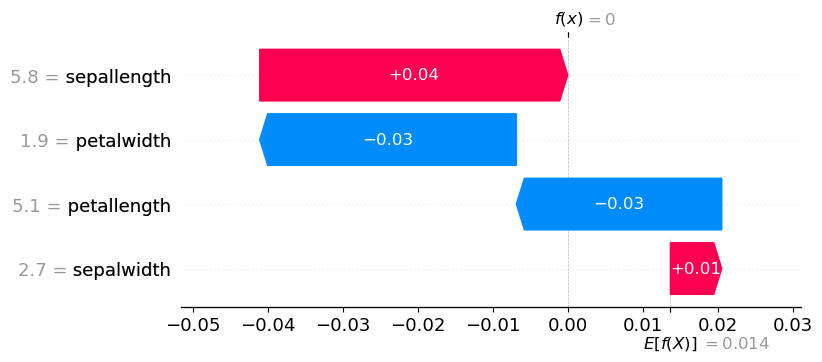

(None, -0.0136986301369863)

In [72]:
shap.plots.waterfall(part_two_shap_values[4]), sum(part_two_shap_values[30].values)

In [78]:
f[np.argwhere(f=='sepallength')]

array([['sepallength']], dtype='<U11')

In [63]:
a = part_two_shap_values[1].values
top_n = 2
ind =  np.abs(a).argsort()[-top_n:][::-1]
f = np.array(part_two_shap_values.feature_names)[ind]

a = part_two_shap_values[0].values
top_n = 2
ind =  np.abs(a).argsort()[-top_n:][::-1]
ff = np.array(part_two_shap_values.feature_names)[ind]
res = set(f).intersection({"a"})
res == set()

True

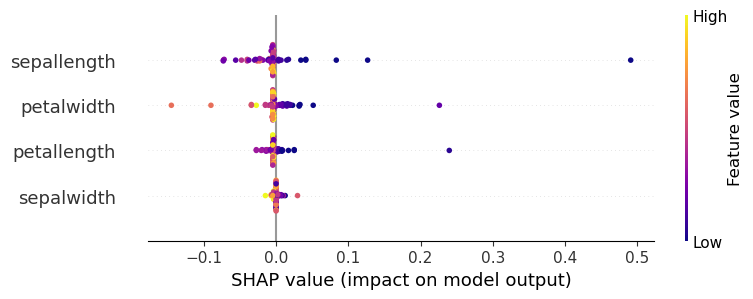

In [8]:
shap.summary_plot(part_two_shap_values,
                  X_label.values,
                  cmap = "plasma")

In [ ]:
shap.plots.bar(part_two_shap_values[1])

TypeError: object of type 'numpy.float64' has no len()

In [ ]:
type(part_two_shap_values[1])

shap._explanation.Explanation

# COBRAS - test 

In [1]:
import numpy as np
from sklearn import metrics, datasets

import warnings
warnings.filterwarnings("ignore")

from cobras_ts.cobras_kmeans import COBRAS_kmeans
from cobras_ts.querier.labelquerier import LabelQuerier
from cobras_ts.querier.commandlinequerier import CommandLineQuerier


budget = 10

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:,:]
labels = iris.target

clusterer = COBRAS_kmeans(X, LabelQuerier(labels), budget)
clustering, intermediate_clusterings, runtimes, ml, cl = clusterer.cluster()

print(metrics.adjusted_rand_score(clustering.construct_cluster_labeling(),labels))

0.6422512518362898


In [2]:
clustering.clusters

In [4]:
cluster1 = clustering.clusters[0]
cluster1.get_all_points()

[100,
 102,
 103,
 104,
 105,
 107,
 108,
 109,
 112,
 115,
 116,
 117,
 118,
 120,
 122,
 124,
 125,
 128,
 129,
 130,
 131,
 132,
 135,
 136,
 137,
 139,
 140,
 141,
 143,
 144,
 145,
 148,
 50,
 51,
 52,
 54,
 56,
 58,
 63,
 65,
 68,
 70,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 83,
 85,
 86,
 87,
 91,
 97,
 101,
 110,
 111,
 113,
 114,
 119,
 121,
 123,
 126,
 127,
 133,
 134,
 138,
 142,
 146,
 147,
 149]

In [9]:
si1, si2 = cluster1.super_instances
si1, si2

(<cobras_ts.superinstance_kmeans.SuperInstance_kmeans at 0x2044c794040>,
 <cobras_ts.superinstance_kmeans.SuperInstance_kmeans at 0x2044c794ca0>)

In [22]:
si2

In [43]:
si2 in cluster1.super_instances

True

In [36]:
list(clustering.get_cluster_to_generalized_super_instance_map().values())

[[[<cobras_ts.superinstance_kmeans.SuperInstance_kmeans at 0x2044c794040>],
 [[<cobras_ts.superinstance_kmeans.SuperInstance_kmeans at 0x2044c794dc0>]],
 [[<cobras_ts.superinstance_kmeans.SuperInstance_kmeans at 0x2044c794d30>,

In [44]:
my_dict

defaultdict(list,
            {<cobras_ts.cluster.Cluster at 0x2044c7940a0>: [[<cobras_ts.superinstance_kmeans.SuperInstance_kmeans at 0x2044c794040>],
             <cobras_ts.cluster.Cluster at 0x2044c794160>: [[<cobras_ts.superinstance_kmeans.SuperInstance_kmeans at 0x2044c794dc0>]],
             <cobras_ts.cluster.Cluster at 0x2044c794b80>: [[<cobras_ts.superinstance_kmeans.SuperInstance_kmeans at 0x2044c794d30>,
               <cobras_ts.superinstance_kmeans.SuperInstance_kmeans at 0x2044c794d90>]]})

In [107]:
def get_cluster_and_all_super_instances(super_instance):
    """Function that looks for the super instances leading to the same cluster.
    Objective: Look for all the partitions that are refering to the same cluster. 

    Args:
        super_instance (cobras_ts.superinstance_kmeans.SuperInstance_kmeans): a super instance

    Returns:
        dict: The key is of type:   cobras_ts.cluster.Cluster
              The value is of type: list(cobras_ts.superinstance_kmeans.SuperInstance_kmeans) representing the same cluster
    """
    my_dict = clustering.get_cluster_to_generalized_super_instance_map()
    return [{k:c} for k, v in my_dict.items() if [super_instance] in v][0]

In [118]:
resul = get_cluster_and_all_super_instances(si1)

In [119]:
list(resul.keys())[0]

In [88]:
cluster1.get_all_points()

In [89]:
merged